In [1]:
!gdown 1Pm8OIwHcCXER0FFsjnppwyBTx6KaGxxD

Downloading...
From: https://drive.google.com/uc?id=1Pm8OIwHcCXER0FFsjnppwyBTx6KaGxxD
To: /content/grant_data_imb.csv
100% 822k/822k [00:00<00:00, 88.3MB/s]


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

Загрузите данные из csv файла. Ознакомьтесь с ними, проверьте наличие пропусков, узнайте типы признаков.

Подготовьте данные к обучению моделей:

Отделите целевую переменную Grant.Status;

Заполните пропуски

в количественных признаках заполните пропуски средними значениями и нулями (у каждой фичи будет по два варианта),

в категориальных признаках выведите значения, которые они принимают, и найдите признак, где пропуски можно заполнить осмысленным значением. В остальных признаках заполните пропуски значением по умолчанию;

Преобразуйте категориальные признаки в количественные с помощью прямого кодирования;

Разделите данные на обучающую и тестовую части;

Используйте масштабирование для получения признаков одинакового масштаба.

Изучите распределение по целевой переменной, чтобы выяснить, сбалансированы ли классы. Если классы не сбалансированы, используйте в работе хотя бы один из изученных методов борьбы с дисбалансом классов;

Обучите модели и выберите лучшую:

Обучите модель логистической регрессии, используя кросс-валидацию. Оцените ее качество с помощью метрики rocauc. Выведите топ-10 признаков по важности, согласно обученной модели;

Обучите модель случайного леса

Для подбора гиперпараметров и кросс-валидации используйте структуру GridSearchCV,

Выберите наилучший вариант случайного леса и выведите его параметры,

Оцените качество выбранной модели с помощью метрики rocauc,

Выведите топ-10 признаков по важности. Используйте атрибут feature_importances_, чтобы узнать важность признаков в деревянных моделях.

Напишите вывод, в котором будет содержаться информация о том, какие признаки важны согласно обеим моделям, и какая модель оказалась наилучшей для решения поставленной задачи.

In [3]:
df = pd.read_csv('grant_data_imb.csv')

In [4]:
features = df.drop(['Grant.Status'], axis = 1)
target = df['Grant.Status']

Выделяем из датасета количественные фичи, заполняем пропуски нулями и медианами, получаем новые количественные фичи

In [5]:
numeric = features.select_dtypes(include=['float', 'int'])
zero = numeric.fillna(0)
zero.columns = 'zero_fill_' + zero.columns
med = numeric.median()
medians = numeric.fillna(med)
medians.columns = 'median_fill_' + medians.columns
numeric = pd.concat([zero, medians], axis=1)

Выделяем категориальные фичи из датасета, анализируем их на пропуски

In [6]:
object_features = features.select_dtypes(include=['object'])
for column in object_features:
     unique_values = object_features[column].unique()
     print(f'Unique values in {column}: {unique_values}')

Unique values in Sponsor.Code: ['97A' '36D' '317A' '62B' '1A' '4D' '2B' '60D' '21A' '149A' '252D' '65A'
 '40D' '24D' '34B' '166B' '6B' '29A' '5A' '141A' nan '32D' '89A' '52D'
 '18B' '33A' '91C' '12D' '20D' '66B' '145A' '179C' '86B' '42B' '183C'
 '112D' '234B' '49A' '437A' '77A' '83C' '93A' '229A' '84D' '196D' '281A'
 '69A' '161A' '51C' '226B' '269A' '188D' '94B' '173A' '221A' '9A' '126B'
 '133A' '101A' '215C' '172D' '138B' '219C' '59C' '315C' '205A' '247C'
 '194B' '15C' '3C' '55C' '204D' '90B' '163C' '307C' '206B' '95C' '7C'
 '180D' '214B' '197A' '349A' '232D' '325A' '266B' '164D' '63C' '228D'
 '187C' '208D' '241A' '48D' '309A' '73A' '28D' '362B' '39C' '67C' '212D'
 '200D' '148D' '154B' '245A' '311C' '105A' '47C' '222B' '137A' '159C'
 '100D' '143C' '193A' '324D' '38B' '75C' '427C' '103C' '415C' '139C'
 '107C' '136D' '11C' '170B' '135C' '203C' '235C' '331C' '259C' '87C'
 '169A' '284D' '198B' '308D' '242B' '174B' '68D' '120D' '347C' '294B'
 '128D' '56D' '202B' '435C' '80D' '130B' '54B' '

Заменяем With.PHD.1: nan на No

In [7]:
object_features['With.PHD.1'].fillna('No',inplace=True)

In [8]:
object_features = pd.get_dummies(object_features)

In [9]:
features = pd.concat([numeric, object_features], axis=1)

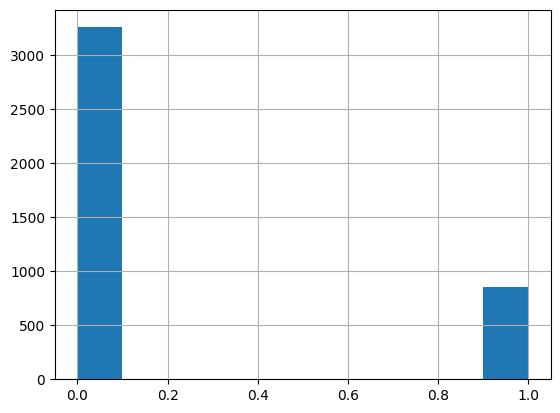

In [10]:
target.hist();

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
model = LogisticRegressionCV(random_state=42, solver='liblinear', class_weight='balanced', cv=5)
model.fit(X_train, y_train)
predict_proba_test = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, predict_proba_test)

0.6596681473739221

In [26]:
feature_importances = model.coef_[0]

top_10_features_idx = np.argsort(np.abs(feature_importances))[::-1][:10]
lr_top_10_features = [features.columns[i] for i in top_10_features_idx]

for feature in lr_top_10_features:
    print(feature)

zero_fill_Number.of.Unsuccessful.Grant.1
median_fill_Number.of.Unsuccessful.Grant.1
median_fill_Number.of.Successful.Grant.1
zero_fill_Number.of.Successful.Grant.1
median_fill_A..1
zero_fill_A..1
median_fill_C.1
zero_fill_C.1
zero_fill_Faculty.No..1
median_fill_Faculty.No..1


In [22]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc')

grid_search.fit(X_train, y_train)

print("Лучшие параметры случайного леса:", grid_search.best_params_)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC:", roc_auc)

feature_importances = best_rf.feature_importances_

top_10_features_idx = np.argsort(np.abs(feature_importances))[::-1][:10]
rf_top_10_features = [features.columns[i] for i in top_10_features_idx]

for feature in rf_top_10_features:
    print(feature)

Лучшие параметры случайного леса: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
ROC AUC: 0.7214179949481753
median_fill_Number.of.Unsuccessful.Grant.1
zero_fill_Number.of.Unsuccessful.Grant.1
zero_fill_Number.of.Successful.Grant.1
median_fill_Number.of.Successful.Grant.1
Contract.Value.Band...see.note.A_A 
zero_fill_Person.ID.1
zero_fill_RFCD.Code.1
zero_fill_SEO.Code.1
median_fill_SEO.Code.1
zero_fill_Dept.No..1


In [24]:
rf_top_10_features = [features.columns[i] for i in top_10_features_idx]
for feature in rf_top_10_features:
    print(feature)

median_fill_Number.of.Unsuccessful.Grant.1
zero_fill_Number.of.Unsuccessful.Grant.1
zero_fill_Number.of.Successful.Grant.1
median_fill_Number.of.Successful.Grant.1
Contract.Value.Band...see.note.A_A 
zero_fill_Person.ID.1
zero_fill_RFCD.Code.1
zero_fill_SEO.Code.1
median_fill_SEO.Code.1
zero_fill_Dept.No..1


In [28]:
set(lr_top_10_features) & set(rf_top_10_features)

{'median_fill_Number.of.Successful.Grant.1',
 'median_fill_Number.of.Unsuccessful.Grant.1',
 'zero_fill_Number.of.Successful.Grant.1',
 'zero_fill_Number.of.Unsuccessful.Grant.1'}

Для обоих моделей данные {'median_fill_Number.of.Successful.Grant.1',
 'median_fill_Number.of.Unsuccessful.Grant.1',
 'zero_fill_Number.of.Successful.Grant.1',
 'zero_fill_Number.of.Unsuccessful.Grant.1'} вошли в топ 10 по важности, классификатор на основе случайного показал лучшие результаты.